In [1]:
%matplotlib inline


# Modeling and fitting


## Introduction

In practice, we have to:

- Read a DL4 datasets file
- Define the `~gammapy.modeling.models.Models` to apply to the datasets from a list of `~gammapy.modeling.models.SkyModel`.
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for
  the spectral part of the fit.


## Setup

As usual, we’ll start with some setup …




In [2]:
from pathlib import Path

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt

from IPython.display import display
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges

from gammapy.modeling import Fit
from gammapy.modeling.models import (
    PointSpatialModel,
    LogParabolaSpectralModel,
    SkyModel,
    Models
)


## Read the DL4 datasets

To read datasets from disk you can use `Datasets.read`:


In [3]:
filename = "./datasets/crab_1d/datasets_crab_1d.yaml"

datasets = Datasets.read(filename)


/Users/qremy/Work/GitHub/gammapy/gammapy/utils/scripts.py:65: UserWarning: Checksum verification failed for datasets/crab_1d/datasets_crab_1d.yaml.
  warnings.warn(f"Checksum verification failed for {filename}.", UserWarning)


In [4]:
print(datasets.names)

['_hess_obs23523', '_hess_obs23526', '_hess_obs23559', '_hess_obs23592']


## Define models

In [5]:
target_postion = SkyCoord.from_name("Crab Nebula")
spatial_model = PointSpatialModel.from_position(target_postion)
spatial_model.freeze() # frozen for 1D analysis

# we can set some limit on the parameters
# for example on the source position
shift_max = 0.2 
spatial_model.lon_0.max = spatial_model.lon_0.value + shift_max
spatial_model.lon_0.min = spatial_model.lon_0.value - shift_max
spatial_model.lat_0.max = spatial_model.lat_0.value + shift_max
spatial_model.lat_0.min = spatial_model.lat_0.value - shift_max

spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2.,
    beta=0.,
    reference=1 * u.TeV,
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name="crab")

models = Models([model])


Models can be saved to file :

In [6]:
path = Path("models")
path.mkdir(exist_ok=True)

filename = path / "models_crab.yaml"
models.write(filename, overwrite=True)

Alternatively you can read the models from file 

In [7]:
filename = "models_crab.yaml"
models = Models.read(filename)

then we set the models on tha datasets

In [8]:
datasets.models = models

## Fit spectrum

Now we’ll fit a global model to the spectrum. First we do a joint
likelihood fit to all observations. If you want to stack the
observations see below. We will also produce a debug plot in order to
show how the global fit matches one of the individual observations.




In [9]:
optimize_opts = dict(strategy=1, tolerance=0.1)
fit = Fit(optimize_opts=optimize_opts)
result_hess = fit.run(datasets=datasets)


We make a copy of the best-fit models to use them later.

In [10]:
models_best_hess = datasets.models.copy()

## Fit quality and model residuals




We can access the results dictionary to see if the fit converged:




In [11]:
print(result_hess)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 168
	total stat : 88.54

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



You can look into more details  of the minuit optimizer output

In [12]:
print(result_hess.minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.54                      │              Nfcn = 168              │
│ EDM = 2.48e-06 (Goal: 0.0002)    │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

and check the best-fit parameters




In [13]:
display(result_hess.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str4,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
crab,,amplitude,4.3645e-11,cm-2 s-1 TeV-1,2.454e-12,nan,nan,False,True,,
crab,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
crab,,alpha,2.3243e+00,,1.433e-01,nan,nan,False,False,,
crab,,beta,1.9830e-01,,8.565e-02,nan,nan,False,False,,
crab,,lon_0,8.3629e+01,deg,0.000e+00,8.343e+01,nan,True,False,,
crab,,lat_0,2.2015e+01,deg,0.000e+00,2.181e+01,9.000e+01,True,False,,


A simple way to inspect the model residuals is using the function
`~SpectrumDataset.plot_fit()`




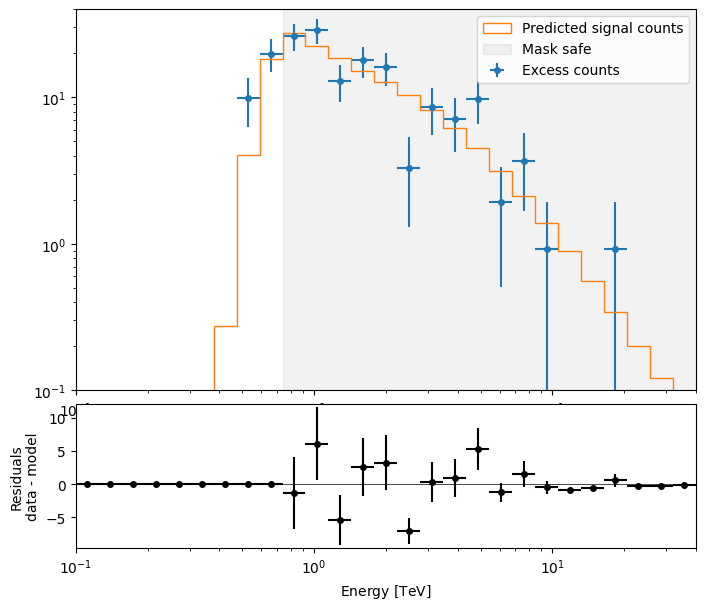

In [14]:
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 40)
datasets[0].plot_masks(ax=ax_spectrum)
plt.show()

For more ways of assessing fit quality, please refer to the dedicated tutorial :
https://docs.gammapy.org/1.2/tutorials/api/fitting.html



## Compute Flux Points

To round up our analysis we can compute flux points by fitting the norm
of the global model in energy bands.
We can utilise the `~gammapy.estimators.utils.resample_energy_edges`
for defining the energy bins in which the minimum number of `sqrt_ts` is 2.
To do so we first stack the individual datasets, only for obtaining the energies:




In [15]:
dataset_stacked = datasets.stack_reduce()
energy_edges = resample_energy_edges(dataset_stacked, conditions={"sqrt_ts_min": 2})

Now we create an instance of the
`~gammapy.estimators.FluxPointsEstimator`, by passing the dataset and
the energy binning:




In [16]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab", selection_optional="all"
)
flux_points_hess = fpe.run(datasets=datasets)

Here is a the table of the resulting flux points:




In [17]:
display(flux_points_hess.to_table(sed_type="dnde", formatted=True))

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float32[4],float64,float64,float64[11],bool,float64[4],bool,float64[11]
0.659,0.590,0.737,1.137e-10,1.659e-11,1.731e-11,1.590e-11,1.498e-10,136.046,11.664,0.0 .. 0.0,0.0 .. 0.0,0.238,136.284,62.312 .. 234.240,False,0.0 .. 0.0,True,0.200 .. 5.000
0.823,0.737,0.920,7.047e-11,7.380e-12,7.618e-12,7.145e-12,8.619e-11,312.860,17.688,31.265117564402374 .. 23.62317629499738,28.511234 .. 21.430532,8.325,321.185,138.832 .. 442.156,False,29.0 .. 25.0,True,0.200 .. 5.000
1.028,0.920,1.148,3.887e-11,4.666e-12,4.842e-12,4.494e-12,4.890e-11,245.598,15.672,22.755846136724404 .. 16.797329612167175,21.415327 .. 15.580717,10.175,255.773,104.045 .. 388.506,False,30.0 .. 17.0,True,0.200 .. 5.000
1.283,1.148,1.434,2.223e-11,2.995e-12,3.123e-12,2.870e-12,2.874e-11,204.730,14.308,17.94767297444903 .. 12.73362858955514,16.964312 .. 11.860861,3.004,207.735,76.601 .. 317.487,False,14.0 .. 17.0,True,0.200 .. 5.000
1.602,1.434,1.790,1.529e-11,2.086e-12,2.176e-12,1.998e-12,1.982e-11,202.941,14.246,17.831506857230753 .. 11.813731572219067,16.671816 .. 11.244619,0.588,203.529,84.148 .. 228.970,False,19.0 .. 13.0,True,0.200 .. 5.000
2.000,1.790,2.235,7.984e-12,1.255e-12,1.317e-12,1.194e-12,1.075e-11,145.702,12.071,13.858067232378481 .. 9.114665726778588,12.840318 .. 8.470059,3.548,149.250,61.416 .. 203.100,False,17.0 .. 7.0,True,0.200 .. 5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.859,4.348,5.429,6.816e-13,1.872e-13,2.035e-13,1.717e-13,1.123e-12,41.611,6.451,4.785209141677064 .. 2.8751106065145713,4.5333247 .. 2.7398167,11.902,53.512,30.408 .. 76.977,False,10.0 .. 3.0,True,0.200 .. 5.000


Now we plot the flux points and their likelihood profiles. For the
plotting of upper limits we choose a threshold of TS < 4.




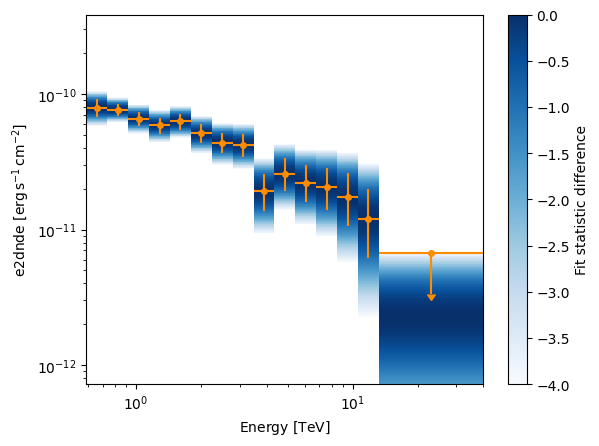

In [18]:
fig, ax = plt.subplots()
flux_points_hess.plot(ax=ax, sed_type="e2dnde", color="darkorange")
flux_points_hess.plot_ts_profiles(ax=ax, sed_type="e2dnde")
plt.show()

The final plot with the best fit model, flux points and residuals can be
quickly made like this:




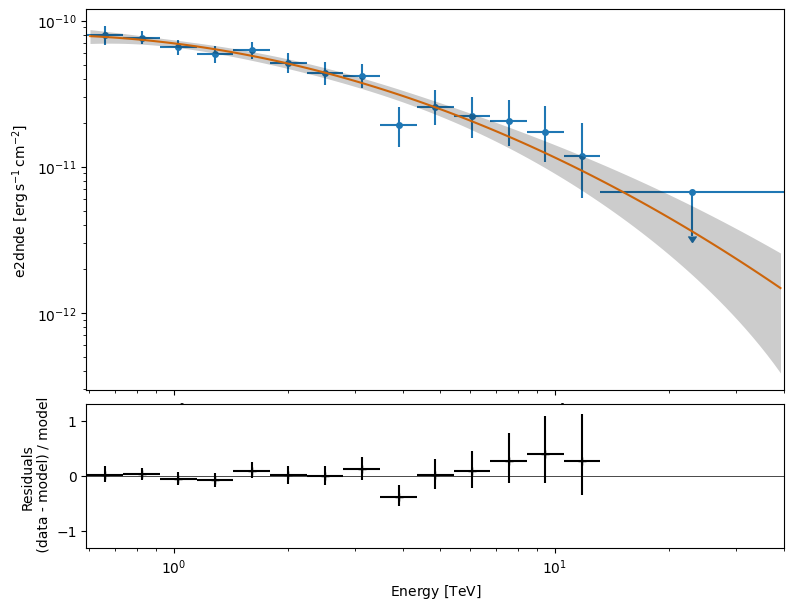

In [19]:
flux_points_dataset_hess = FluxPointsDataset(data=flux_points_hess, models=models_best_hess)
flux_points_dataset_hess.plot_fit()
plt.show()

**In the next notebook we add data from other instruments and perform a joint fit.**